In [42]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset

import pydicom
from tqdm import tqdm

In [43]:
from config import Device

device = Device.device
print(device)

cuda


In [44]:
def find_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"
    
device = torch.device(find_device())
device

device(type='cuda')

In [45]:
# reading a DICOM file
# !pip install pydicom

In [46]:
# download the original raw data
#!pip install gdown

#!gdown --id 1Z67yKzNNqaXfa0UglcodL5Q3L0pMN-dt

In [47]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [48]:
#!unzip iaaa-mri-train.zip

In [49]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [50]:
# checkout number of folders and files (shell commands)

!echo "Number of files:"
!find /Users/anazarnia/data_science/iaaa/data -type f | wc -l

!echo "Number of directories:"
!find /Users/anazarnia/data_science/iaaa/data -type d | wc -l

"Number of files:"


'wc' is not recognized as an internal or external command,
operable program or batch file.


"Number of directories:"


'wc' is not recognized as an internal or external command,
operable program or batch file.


In [51]:
# train.csv

df = pd.read_csv("train.csv")

In [52]:
print(len(df))
print(df.head(5))

3132
                                   SeriesInstanceUID  prediction
0  1.3.46.670589.11.10042.5.0.6048.20240307143704...           0
1  1.3.46.670589.11.10042.5.0.6048.20240307143746...           0
2  1.3.46.670589.11.10042.5.0.6048.20240307143846...           0
3  1.3.46.670589.11.10042.5.0.4776.20240217030800...           0
4  1.3.46.670589.11.10042.5.0.4776.20240217030846...           0


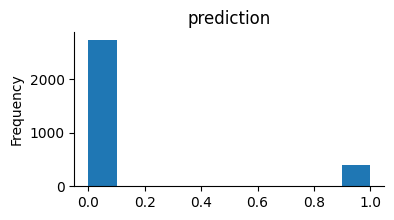

In [53]:
# dataframe analytic

from matplotlib import pyplot as plt

plt.figure(figsize=(4,2))
df['prediction'].plot(kind='hist', bins=10, title='prediction')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [54]:
dicom_file = pydicom.dcmread('C:\\Users\\asus\\Desktop\\iaaa-mri-train\\data\\1.3.46.670589.11.10042.5.0.920.2023123109160568667\\1.3.46.670589.11.10042.5.0.920.2023123109165048675.dcm')

print(dicom_file)   # DICOM metadata

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.10118984576011047191449425386920282692
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.30071.8
(0002, 0013) Implementation Version Name         SH: 'fo-dicom 5.1.1'
(0002, 0016) Source Application Entity Title     AE: 'ACHIVA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_SE', 'M', 'SE']
(0008, 0012) Instance Creation Date              DA: '20231231'
(0008, 0013) Instance Creation Time              TM: '120553'
(0008, 0014) Instance Creator U

In [55]:
dir(dicom_file)

['AccessionNumber',
 'AcquisitionDate',
 'AcquisitionDuration',
 'AcquisitionMatrix',
 'AcquisitionNumber',
 'AcquisitionTime',
 'AdmittingDiagnosesDescription',
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'CodeMeaning',
 'CodeValue',
 'CodingSchemeDesignator',
 'Columns',
 'CommentsOnThePerformedProcedureStep',
 'ContentDate',
 'ContentTime',
 'DeidentificationMethodCodeSequence',
 'DeviceSerialNumber',
 'DiffusionBValue',
 'DiffusionGradientOrientation',
 'EchoNumbers',
 'EchoTime',
 'EchoTrainLength',
 'FilmConsumptionSequence',
 'FlipAngle',
 'FrameOfReferenceUID',
 'HeartRate',
 'HighBit',
 'HighRRValue',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'ImageType',
 'ImagedNucleus',
 'ImagingFrequency',
 'InPlanePhaseEncodingDirection',
 'InstanceCreationDate',
 'InstanceCreationTime',
 'InstanceCreatorUID',
 'InstanceNumber',
 'InstitutionName',
 'InstitutionalDepartmentName',
 'IntervalsAcquired',
 'IntervalsRejected',
 'LossyImageCompression',
 'LowRRValue',
 '

In [56]:
# check the shape of the image
dicom_file.pixel_array.shape

(288, 288)

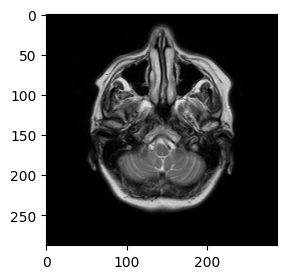

In [57]:
# extacting and display the image data

image_data = dicom_file.pixel_array

plt.figure(figsize=(3,3))
plt.imshow(image_data, cmap=plt.cm.gray)
plt.show()

In [58]:
# transforms.ToTensor -> adds one dimension to the image
print(image_data.shape)

to_tensor = transforms.ToTensor()
image_tensor = to_tensor(image_data)
print(image_tensor.size())

(288, 288)
torch.Size([1, 288, 288])


In [59]:
# patient_list = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# train_patients, test_patients = train_test_split(patient_list, test_size=0.2, shuffle=True, random_state=42)

In [60]:
class MRIDataset(Dataset):
    def __init__(self, data_path, labels_path, split="train", transform=None, max_slices=None, random_state=42):
        super().__init__()
        self.data_path = data_path
        self.labels_path = labels_path
        self.transform = transform
        self.max_slices = max_slices

        self.labels = pd.read_csv(labels_path)
        
        normal_path = list(self.labels[self.labels['prediction'] == 0].reset_index(drop=True)["SeriesInstanceUID"])
        abnormal_path = list(self.labels[self.labels['prediction'] == 1].reset_index(drop=True)["SeriesInstanceUID"])

        normal_val_samples = int(len(normal_path) * 0.2)
        abnormal_val_samples = int(len(abnormal_path) * 0.2)

        if split == "train":
            self.patient_list = normal_path[normal_val_samples*2:] + abnormal_path[abnormal_val_samples*2:]
        elif split == "val":
            self.patient_list = normal_path[:normal_val_samples] + abnormal_path[:abnormal_val_samples]
        elif split == "test":
            self.patient_list = normal_path[normal_val_samples: normal_val_samples*2] + abnormal_path[abnormal_val_samples: abnormal_val_samples*2]

        random.Random(random_state).shuffle(self.patient_list)

    def __len__(self):
        return len(self.patient_list)
    
    def __getitem__(self, idx):
        patient_id = self.patient_list[idx]
        images = self.load_patient_images(patient_id)

        if self.transform:
            images = [self.transform(image) for image in images]
        else:
            images = [torch.tensor(img, dtype=torch.float32) for img in images]
        
        images = torch.stack(images) # [18,1,h,w] stack images along the 0th dimension
        images = images.squeeze(1) # [18,h,w] remove the channel dimension

        label = self.labels[self.labels['SeriesInstanceUID'] == patient_id]['prediction'].values
        label = torch.tensor(label, dtype=torch.long)

        return images, label    
    
    def load_patient_images(self, patient_id):

        patient_dir = os.path.join(self.data_path, patient_id)
        dcm_paths = [os.path.join(patient_dir, f) for f in os.listdir(patient_dir) if f.endswith('.dcm')]

        images = []
        for dcm_path in dcm_paths:
            dcm_data = pydicom.dcmread(dcm_path)
            image_array = dcm_data.pixel_array
            image_array = image_array / np.max(image_array) # normalize the image
            images.append(image_array)
           
        # pad the images to max_slices
        if self.max_slices:
            padding_needed = self.max_slices - len(images)
            if padding_needed > 0:
                padding_image = np.zeros_like(images[0])
                images.extend([padding_image] * padding_needed)

        return images
    

In [61]:
from datasets import MRIDataset

data_path = os.path.join("C:\\Users\\asus\\Desktop\\iaaa-mri-train", "data")
labels_path = "train.csv"
batch_size = 32

resize_transform = transforms.Compose([
    transforms.ToTensor(),  # converts image to tensor of shape (1, h, w)
    transforms.Resize((256, 256)),  # resize to 256x256
    transforms.Lambda(lambda x: x.type(torch.float32))
])

train_dataset = MRIDataset(
    data_path, labels_path, split="train", transform=resize_transform, max_slices=20)
val_dataset = MRIDataset(data_path, labels_path, split="val",
                         transform=resize_transform, max_slices=20)
test_dataset = MRIDataset(
    data_path, labels_path, split="test", transform=resize_transform, max_slices=20)


train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size)

In [62]:
image_, label_ = next(iter(train_dataset))
print(image_.size())
print(label_)

torch.Size([20, 256, 256])
tensor([0])


In [63]:
image_, label_ = next(iter(train_dl))
print(image_.size())
print(label_.size())

torch.Size([32, 20, 256, 256])
torch.Size([32, 1])


In [64]:
print(len(train_dataset))
print(len(test_dataset))

1880
626


In [65]:
print(len(train_dl))
print(len(test_dl))

59
20


In [66]:
# the model

class CNN(nn.Module):
    def __init__(self, in_channels=20, out_channels=1):
        super().__init__()

        self.cnn1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=5) 
        # size-> (64,252,252)
        self.maxpool = nn.MaxPool2d(kernel_size=2) 
        # size -> (64,126,126)
        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5) 
        # size -> (128,122,122)
        # maxpool -> (128,61,61)
        self.fc1 = nn.Linear(128*61*61, 300)
        self.fc2 = nn.Linear(300,1)

    def forward(self, x):
        x = F.relu(self.cnn1(x))
        x = self.maxpool(x)
        x = F.relu(self.cnn2(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1) # flatten

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [67]:
data_, _ = next(iter(train_dl))
model = CNN()
model(data_).size()

torch.Size([32, 1])

In [68]:
# loss and optimizer

epochs = 10
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [69]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [70]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0.0

    #batch 
    for images, labels in tqdm(train_dl):


        images = images.to(device=device)
        labels = labels.to(device=device)

        labels = labels.float() # BCEWithLogitsLoss expect folats

        #forward pass
        outputs = model(images) # torch.Size([32, 1])
        loss = criterion(outputs, labels)

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = (outputs > 0).float()  # convert logits to binary predictions
        train_correct += (preds == labels).sum().item()

        # evaluate
        model.eval()
        test_correct = 0.0
        
        with torch.no_grad():
            for images, labels in test_dl:

                images = images.to(device=device)
                labels = labels.to(device=device)

                outputs = model(images)

                preds = (outputs > 0).float()  # convert logits to binary predictions
                test_correct += (preds == labels).sum().item()
        
    train_accuracy = train_correct / len(train_dataset)
    test_accuracy = test_correct / len(test_dataset)

    print(f"Epoch {epoch+1}/{epochs}, train Loss: {train_loss:.4f}, train accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch+1}/{epochs}, test accuracy: {test_accuracy:.4f}")

  0%|          | 0/59 [00:05<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 498.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 2.90 GiB is allocated by PyTorch, and 422.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
torch.save(model.state_dict(), "model_parameters1.pth")

In [ ]:
torch.save(model, 'model1.pth')

In [ ]:
model = CNN().to(device=device)
model.load_state_dict(torch.load("saved_models/model_parameters1.pth"))

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Evaluate
model.eval()
test_correct = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_dl:
        images = images.to(device=device)
        labels = labels.to(device=device)

        outputs = model(images)

        preds = (outputs > 0).float()  # convert logits to binary predictions
        test_correct += (preds == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

test_accuracy = test_correct / len(test_dataset)

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_preds_binary = (all_preds > 0).astype(float)

precision = precision_score(all_labels, all_preds_binary)
recall = recall_score(all_labels, all_preds_binary)
auc = roc_auc_score(all_labels, all_preds)

print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")


In [ ]:
import torch
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import numpy as np

# Early stopping parameters
patience = 5
best_avg_metric = 0
epochs_no_improve = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0.0

    for images, labels in tqdm(train_dl):
        images = images.to(device=device)
        labels = labels.to(device=device)

        labels = labels.float()  # BCEWithLogitsLoss expects floats

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = (outputs > 0).float()  # convert logits to binary predictions
        train_correct += (preds == labels).sum().item()

    train_accuracy = train_correct / len(train_dataset)

    # Evaluate
    model.eval()
    test_correct = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_dl:
            images = images.to(device=device)
            labels = labels.to(device=device)

            outputs = model(images)

            preds = (outputs > 0).float()  # convert logits to binary predictions
            test_correct += (preds == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    test_accuracy = test_correct / len(test_dataset)

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_preds_binary = (all_preds > 0).astype(float)

    precision = precision_score(all_labels, all_preds_binary)
    recall = recall_score(all_labels, all_preds_binary)
    auc = roc_auc_score(all_labels, all_preds)

    avg_metric = (precision + recall + auc) / 3

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch+1}/{epochs}, Test Accuracy: {test_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}, Avg Metric: {avg_metric:.4f}")

    # Early stopping
    if avg_metric > best_avg_metric:
        best_avg_metric = avg_metric
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break


In [ ]:
from torchvision import transforms, models

resnet_model = models.resnet50(pretrained=True)
